# Darknet53 ImageNet Sampleset

## Import

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models import darknet

In [3]:
from pathlib import Path

In [4]:
PATH = Path('data/imagenet')
PATH_TRAIN = PATH/'train'

## Setup

In [5]:
def reset_valset(path):
    path_val = path/'valid'
    path_trn = path/'train'
    
    if not os.path.exists(path_val):
        print('No validation directory to reset.')
        return
    
    for folder in path_val.iterdir():
        for f in folder.iterdir():
            os.rename(f, path_trn / str(f).split('valid/')[-1])

def create_valset(path, p=0.15, seed=0):
    np.random.seed(seed=seed)
    
    path_val = path/'valid'
    path_trn = path/'train'
    reset_valset(path)
    
    # move random p-percent selection from train/ to valid/
    for folder in path_trn.iterdir():
        os.makedirs(path_val/str(folder).split('train/')[-1], exist_ok=True)
        flist = list(folder.iterdir())
        n_move = int(np.round(len(flist) * p))
        fmoves = np.random.choice(flist, n_move, replace=False)
        
        for f in fmoves:
            os.rename(f, path_val / str(f).split('train/')[-1])

def count_files(path):
    count = 0
    for folder in path.iterdir():
        count += len(list(folder.glob('*')))
    return count

In [6]:
create_valset(PATH, p=0.2)
count_files(PATH_TRAIN), count_files(PATH/'valid')

(15565, 3874)

Weight Decay of `1e-5` used bc it's a near what JHoward uses in [CIFAR-10 Darknet notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb). See Fast.ai DL1 bit on Weight Decay in [Lesson 5 - 2:12:01](https://youtu.be/J99NV9Cr75I?t=2h12m1s).

I may experiment with cycle length and cycle split. `lr`, `clr_div`, and `cut_div` values determined by looking at results in the darknet_test.ipynb notebook, and guessing.

In [7]:
bs = 32
sz = 256
wd = 1e-5

darknet53 = darknet.darknet_53()

tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, 
                       max_zoom=1.05, pad=sz//8)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms)

learner = ConvLearner.from_model_data(darknet53, model_data, crit=F.cross_entropy)

 91%|█████████ | 442/487 [32:53<03:20,  4.46s/it, loss=71]  

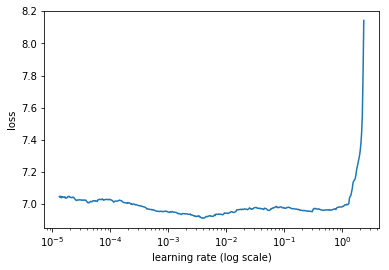

In [8]:
learner.lr_find()
learner.sched.plot()

## Train

In [10]:
learner.fit(lrs=1e-2, n_cycle=1, wds=wd, cycle_len=3, use_clr=(40, 10))

  0%|          | 0/487 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                   
    0      6.591332   6.535328   0.007228  
    1      6.284904   6.388249   0.00826                    
    2      5.974577   5.956076   0.018327                   



[array([5.95608]), 0.018327310273619]

In [11]:
learner.save('darknet53_imagenet_sample_00')

In [ ]:
learner.fit(lrs=1e-2, n_cycle=1, wds=wd, cycle_len=3, use_clr=(40, 10))